# LSTM 감성 분류기

이 노트북에서 LSTM을 사용해 감성에 따라 IMDB 영화 리뷰를 분류합니다.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rickiepark/dl-illustrated/blob/master/notebooks/11-5.lstm_sentiment_classifier.ipynb)

#### 라이브러리 적재

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from tensorflow.keras.layers import LSTM # new! 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

#### 하이퍼파라미터 설정

In [2]:
# 출력 디렉토리
output_dir = 'model_output/LSTM'

# 훈련
epochs = 4
batch_size = 128

# 벡터 공간 임베딩
n_dim = 64 
n_unique_words = 10000 
max_review_length = 100 
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# LSTM 층 구조
n_lstm = 256 
drop_lstm = 0.2

# 밀집 층 구조
# n_dense = 256
# dropout = 0.2

#### 데이터 적재

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # n_words_to_skip 삭제

17473536/17464789 [==============================] - 0s 0us/step


#### 데이터 전처리

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### 신경망 만들기

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(LSTM(n_lstm, dropout=drop_lstm))
# model.add(Dense(n_dense, activation='relu')) 
# model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               328704    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 968,961
Trainable params: 968,961
Non-trainable params: 0
_________________________________________________________________


#### 모델 설정

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 훈련!

In [9]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 12s 22ms/step - loss: 0.4614 - accuracy: 0.7729 - val_loss: 0.3508 - val_accuracy: 0.8470
Epoch 2/4
196/196 [==============================] - 4s 20ms/step - loss: 0.2885 - accuracy: 0.8825 - val_loss: 0.3498 - val_accuracy: 0.8490
Epoch 3/4
196/196 [==============================] - 4s 20ms/step - loss: 0.2401 - accuracy: 0.9078 - val_loss: 0.3634 - val_accuracy: 0.8419
Epoch 4/4
196/196 [==============================] - 4s 20ms/step - loss: 0.2028 - accuracy: 0.9226 - val_loss: 0.4104 - val_accuracy: 0.8398


#### 평가

In [10]:
model.load_weights(output_dir+"/weights.02.hdf5") 

In [11]:
y_hat = model.predict(x_valid)

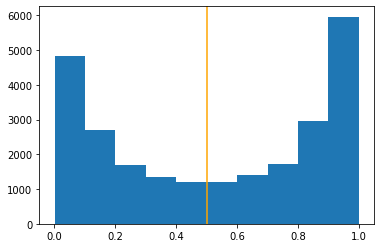

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [13]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'92.69'